* 이번 컴피티션은 이들이 제공한 위성사진을 가지고 배와 빙하를 구분해내는 머신러닝과 딥러닝 모데을 구축하는 컴피티션이다.  
* IMAGE CLASSIFICATION이고 BINARY CLASSIFICATION이다. 
* keras를 사용한 2-D convolutional neural network(CNN)을 배울수 있다.
* keras는 유명한 딥러닝 프레임워크로, 딥러닝 모델을 쉽고 빠르게 구축한다. 
* plotly는 interactive한 visulization을 가능하게 하는 라이브러리이다. 

### CNN
CNN(Convolutional Neural Network)은 이미지를 분석하기 위해 패턴을 찾는데 유용한 알고리즘으로 데이터에서 이미지를 직접 학습하고 패턴을 사용해 이미지를 분류한다. CNN의 핵심적인 개념은 이미지의 공간정보를 유지하며 학습을 할수 있다는 것이다. CNN은 이미지의 형태를 보존하도록 행렬 형태의 데이터를 입력 받기 때문에 이미지를 벡터화 하는 과정에서 발생하는 정보 손실을 방지할 수 있다. 즉 기본 개념은 "행렬로 표현된 필터의 각 요소가 데이터 처리에 적합하도록 자동으로 학습되게 하자"는 것이다.

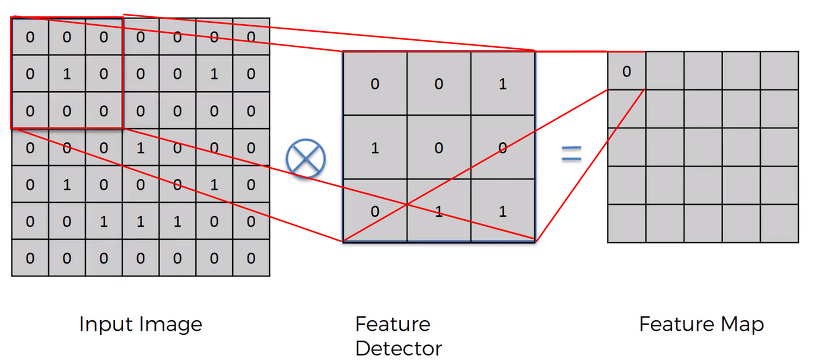


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline

#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

py.init_notebook_mode(connected=True) # plotly 를 jupyter notebook 에 사용하려면 이 커맨드를 입력해야 합니다.

* 데이터들은 json형태로 주어져 있는데 이를 pandas로 pd.read_csv로 자주사용하던 형태가 아니라 pd.read_json으로 읽는다. 
* 또한 이번 파일은 7z형태로 되어있어서 밑에 코드로 이를 열어주도록 한다. 

In [ ]:
!pip install py7zr
import py7zr
import os

if not os.path.exists('/kaggle/train/') :
    os.makedirs('/kaggle/train/')

if not os.path.exists('/kaggle/test/') :
    os.makedirs('/kaggle/test/')

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/train")

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/test")

for dirname, _, filenames in os.walk('/kaggle'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_json('/kaggle/train/data/processed/train.json')
test = pd.read_json('/kaggle/test/data/processed/test.json')

In [ ]:
train.head()

데이터의 형태를 보면 
* id
* feature: band_1, band_2, inc_angle
* target: is_iceberg -> iceberg = 1, ship = 0

In [ ]:
train['inc_angle'].value_counts()

보면 제일 위에 'na'라고 있는데 이는 missing value라고 생각하면 된다고 한다. 그래서 이 값을 바꿔주도록 한다. 

In [ ]:
#na -> 0
train.inc_angle = train.inc_angle.replace('na',0)

그리고 추가적으로 float형태들로 이루어져 있기 때문에 float으로 바꿔주고 시작

이미지들은 위성에서 쏜 radar가 특정 object를 만나서 튕겨서 다시 돌아오게 되는데 이를 이미지로 저장한 것이라고 한다. 

object들이 solid 할수록(land, islands, sea ice, icebergs, ships) 더 강한 rader energy가 reflection해서 실제 이미지에서 더 밝게 나온다고 한다. 이러한 것을 'backscatter'라고 한다 

'backscatter'는 주변 환경에 영향을 많이 받는데, 주변에 바람이 강할수록 이미지가 밝아지고, 바람이 약할수록 이미작 어두워진다, 아마 강한 바람에 담긴 여러 분자들의 운동에너지가 reflection되면서 레이더에 담긴다고 본다. 

이 이미지를 직는 것은 측방 감시 레이더로서 특정 각도로 이미지를 촬용하는 것이다. inc_angle은 band_1.band_2를 바라보는 angle를 의미한다. 

일반적으로 높은 incidence angle(입사각)일수록, ocean background가 어둬진다고 한다. 

band_1, band_2는 이미지로 생각하면 된다.

In [ ]:
len(train.loc[0,'band_1'])

이들이 길이는 5625이고 이들을 학습하기 위해서 이미지 75x75 = 5625이므로 학습하기 좋게 하기 위해서 사이즈를 75x75사이즈로 바꾸고, 2D CNN학습을 위해서 [N, height, width, channel]의 차원을 가지도록 바꿔준다. np.newaxis를 사용하면 쉽게 사용 가능하다.

In [ ]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#np.concatenate해서 새로운 채널을 하나더 만들어주는 것이다 컬러이미지이기 때문에 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

결론적으로 이것은 이렇게 바꿈으로서 3개의 채널로 이루어진 이미지를 얻게 되는 코드이다. train, test에 대해서 실행. 

In [ ]:
#만들어 보기 예시, 예로 14번 추출 값이 0, 즉 이것은 ship이다 
train.loc[14, 'is_iceberg']

In [ ]:
#같은 14번 ship이지만 보는 각에 따라서 나오는 것이 다르다는 것을 보여주는 것 
band1 = X_band_1[14,:,:]
band2 = X_band_2[14,:,:]
#from plotly import tools, 이랗게 import tools를 하면 된다 
fig = tools.make_subplots(rows=1,cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
data = go.Surface(z = band1, colorscale='RdBu_r', scene='scene1', showscale=True)
data1 = go.Surface(z = band2, colorscale='RdBu_r', scene='scene1', showscale=True)

fig['layout'].update(title='3D surface plot for "{}" ', titlefont=dict(size=30), height=800, width=1200)


fig.append_trace(data,1,1)
fig.append_trace(data1,1,2)
py.iplot(fig)

빨간색 봉우리가 ship 의 모양을 나타내며, HH, HV 에 따라 radar 를 보는 방향이 달라 조금 다르게 나오지만, 결국 같은 것을 나타냄을 알 수 있다. 

In [ ]:
#이 사진은 z축을 고려하지 않고 바로 위에서만 바라본 그림이다. 
plt.imshow(band1)
plt.show()

In [ ]:
#이렇게 만드는 방법이 있다. 
label = 'ship'

fig = tools.make_subplots(rows=1, cols=2,  specs=[[{'is_3d': True}, {'is_3d': True}]])
fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r',
                          scene='scene1', showscale=False), 1, 1)
fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 2)

#밑에 이거는 세팅하는것 크기랑, 제목이랑 이렇게
fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=800, width=1200)

py.iplot(fig)

다른 방법 

In [ ]:
def plot_contour_2d(band1, band2, label):
    fig = tools.make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
    fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r',
                          scene='scene1', showscale=False), 1, 1)
    fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 2)
    
    fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=800, width=1200)

    py.iplot(fig)
    
    #여기 밑에 부분은 이제 z축 없이 위에서 보는 부분 보여주는 코드 
    fig, ax = plt.subplots(1,2,figsize=(16,10))
    ax[0].imshow(X_band_1[num,:,:])
    ax[0].set_title('Image from band_1', fontsize=15)
    ax[1].imshow(X_band_2[num,:,:])
    ax[1].set_title('Image from band_2', fontsize=15)
    plt.show()

    

밑에 이제 num부분에 숫자를 입력해서 우리가 원하는 부분을 볼 수 있다. 

In [ ]:
num = 0
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

In [ ]:
#num에 100을 해서 확인해보기 
num = 100
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

약간 이건 num = 0 과는 다른데 봉우리 이외에 다른 빙하들이 좀 있는 다른 모습을 확인 가능하다. 

# Start Deep Learning

* 이제 본격적으로 딥러닝을 시작! 데이터셋은 준비됬으니 신경망 모델을 설계하면 된다. 
* 이미지이기 때문에 2D CNN을 가지고 실시. keras에는 딥러닝에 사용되는 여러 layer들이 내장되어 있기 때문에 우리는 그냥 블록처럼 쌓기만 하면 된다. 

In [ ]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

keras.callbacks를 통해서 loss가 더 줄지 않을 경우 학습을 중지한다. 

# Overall workflow
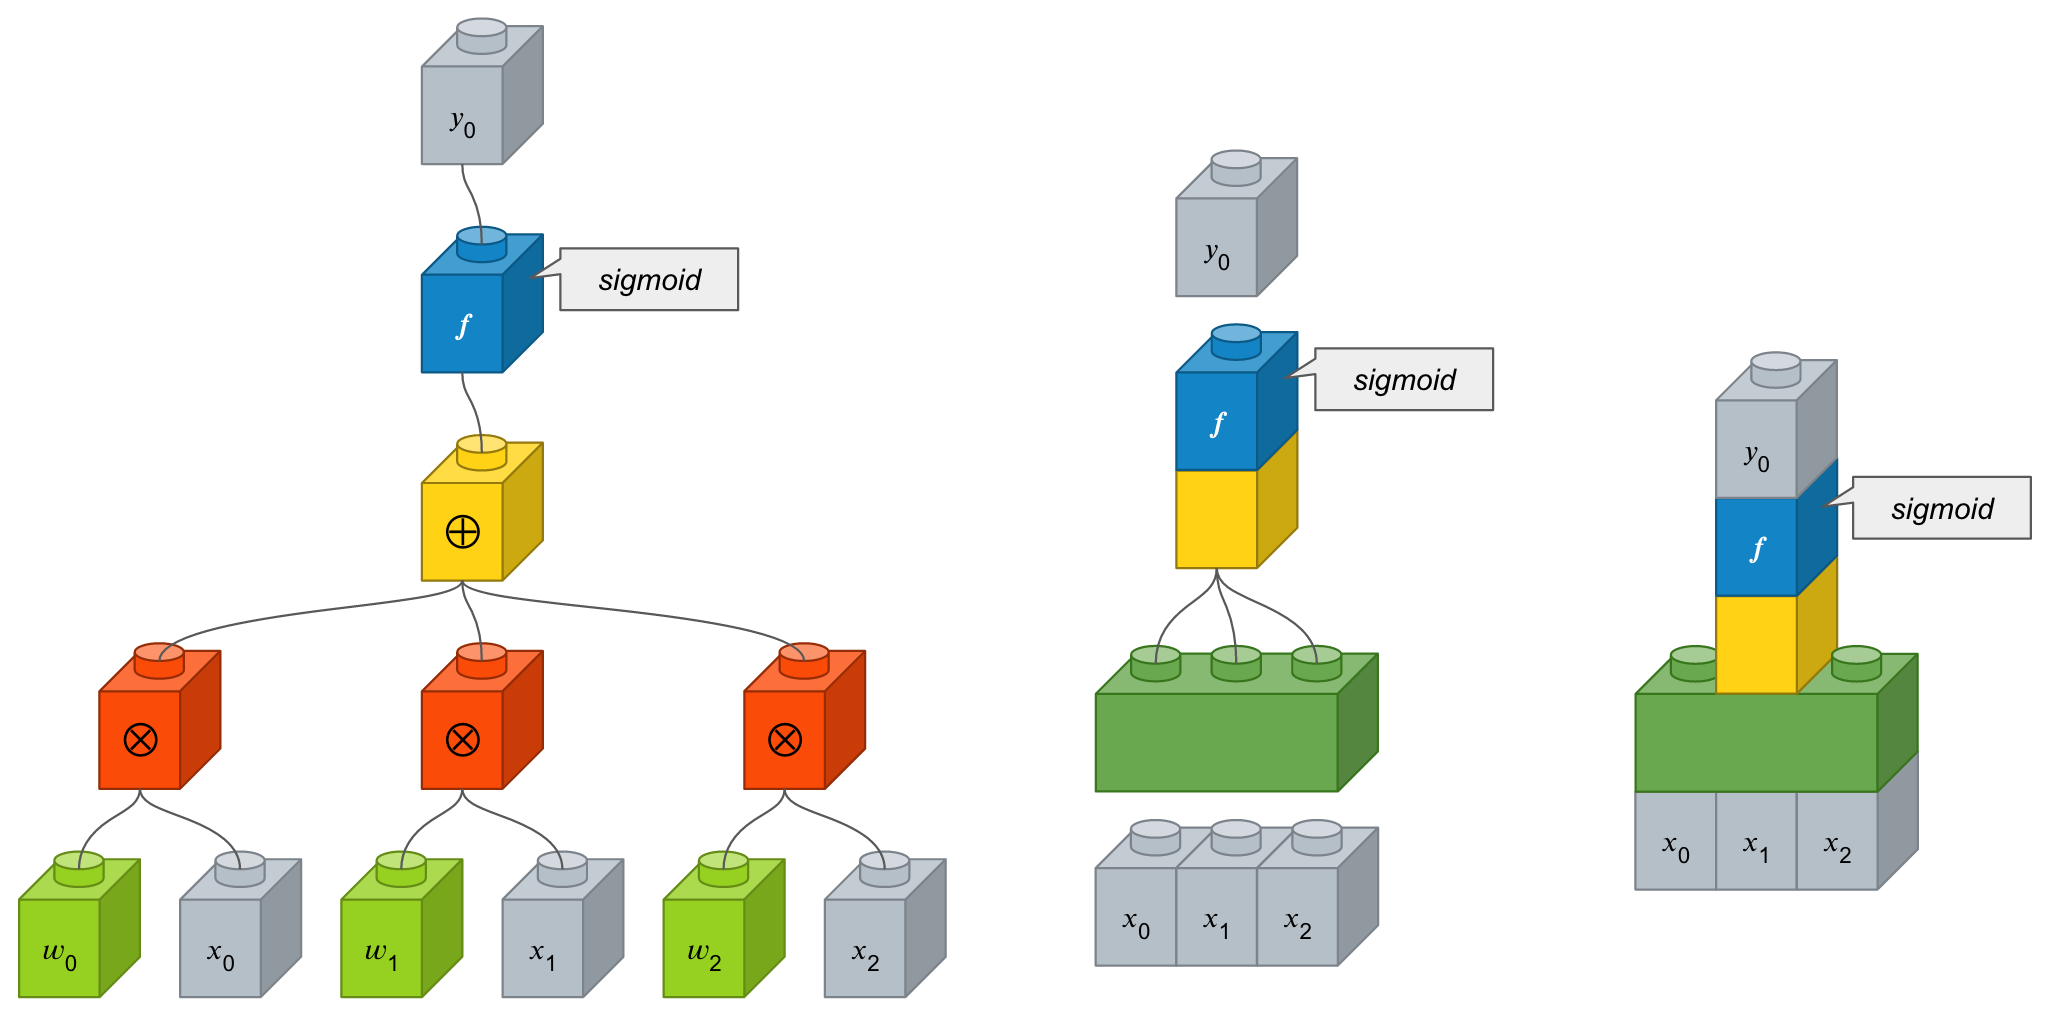
이제 맨 밑에는 input layer -> 빨간색은 이들의 연결 강도를 표현해준것이고 -> 노란색은 dense -> 파란색은 sigmoid

In [ ]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    #Adam 은 모델을 최적화 시켜주는 기능을 한다, 
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

### **Conv2D**
-> 주로 영상 처리에 특화되어 있어서 영상처리쪽에서 많이 사용하는 방법 

gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))

* 첫번째 인자: 64 -> 컨볼루션 필터의 수, 즉 연결되있는 뉴런의 수라고 생각하면 된다  
* 두번째 인자: kernel_size = (3,3) -> 컨볼루션 커널의(행,열)
* 세번재 인자: activation='relu' -> 활성화 함수 설정, rectifier함수로,은익층에 주로 쓰인다 
* *relu: 쉽게 생각해서 0보다 값이 작으면 0을 반환하고, 0보다 큰 값이 나오는 경우 그 값을 그대로 반환하는 함수이다. 
* 네번재 인자: input_shpae(75,75,3) -> 사이즈 75x75 그리고 컬러사진(RGB)이니깐 채널을 3, 흑백인 경우 채널1 

#### ReLU 함수 
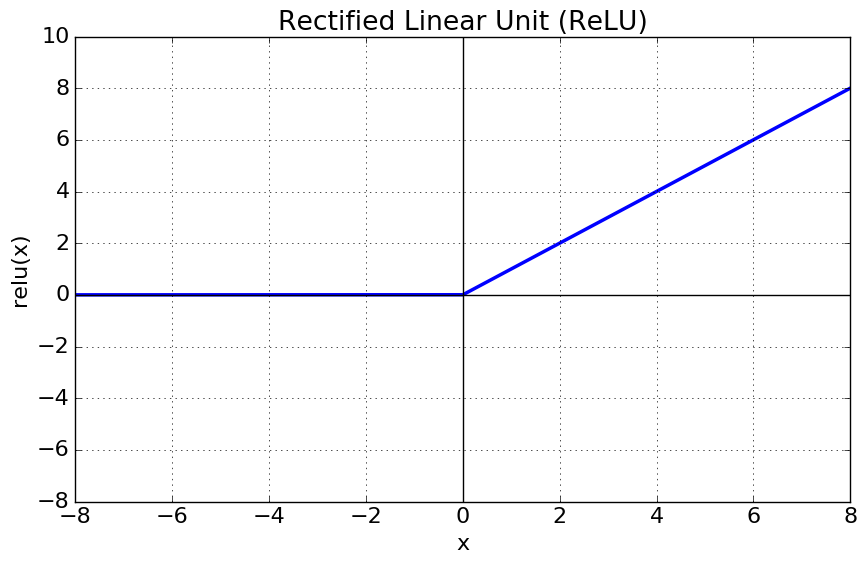![](http://)
* x>0 이면 기울기가 1인 직선이고, x<0이면 함수값이 0이된다.
* sigmoid, tanh 함수와 비교시 학습이 훨씬 빨라진다.
* 연산 비용이 크지않고, 구현이 매우 간단하다.
* x<0인 값들에 대해서는 기울기가 0이기 때문에 뉴런이 죽을 수 있는 단점이 존재한다.


#### Input Shape
처음에 filters 갯수 
Conv2D(filters, kernel_size, padding, input size= 75 x 75인 3개 

필터 갯수만 달라지고 나머지 모양은 비슷 

### MaxPooling2D
목적
1. input size를 줄임.
: 여러번 convolution layer을 반복하게 되는데, 별로 필요하지 않은 자료까지 전부를 다 분석할 필요가 없다. 특징만 뽑아내서, 학습하는 것이 합리적이지 않겠는가? 

2. overfitting을 조절
: input size가 줄어드는 것은 그만큼 쓸데없는 parameter의 수가 줄어드는 것이라고 생각할 수 있다. 훈련데이터에만 높은 성능을 보이는 과적합(overfitting)을 줄일 수 있다.

3. 특징을 잘 뽑아냄.
: pooling을 했을 때, 특정한 모양을 더 잘 인식할 수 있음.

#### pool_size: 
정수 혹은 2개 정수의 튜플, 축소 인수 (가로, 세로). (2, 2)는 인풋을 두 공간 차원에 대해 반으로 축소합니다. 한 정수만 특정된 경우, 동일한 윈도우 길이가 두 차원 모두에 대해 적용됩니다.
#### strides: 
정수, 2개 정수의 튜플, 혹은 None. 보폭 값. None일 경우, 디폴트 값인 pool_size가 됩니다.

### Dropout
:Dropout은 딥러닝 학습에 있어서의 문제중 하나인 Overfitting을 해소하기 위한 방법이다. 요약하자면 hidden layer의 일부 유닛이 동작하지 않게 하여 overfitting 되는 것을 막는 방법이다.
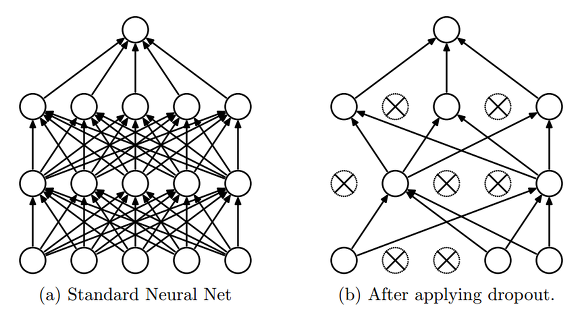
일부로 모델을 덜 똑똑하게 만들어주는 과정이라고 한다.

# Model Evaluation

* 더 나은 모델을 위하여 바로 test를 하는 것이 아니라, 기존 train set 을 train, valid로 나눠서 먼저 모델을 평가해봅니다.
* Sklearn 내장 함수인 train_test_split 을 이용하면 쉽게 할 수 있습니다.

In [ ]:
target_train = train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      target_train,
                                                      random_state=1,
                                                      train_size = 0.8)

In [ ]:
#Without denoising, core features.
gmodel=getModel()
gmodel.fit(X_train, y_train,
          batch_size=24,
          epochs=10,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

* batch_size = 몇 개의 샘플로 가중치를 갱신할 것인지 설정한다.

 예를 들어 배치사이즈가 10인 경우  데이터 10개마다 실제 레이블 값과 비교하기 때문에, 처음에 틀리게 예측하더라도 가중치 업데이트를 하면서 뒤에는 맞추게 될 확률이 높습니다.배치사이즈가 작으면 학습은 촘촘하게 되겠지만 계속 레이블과 비교하고, 가중치를 업데이트하는 과정을 거치면서 시간이 오래 걸립니다.
* epochs = 전체 데이터셋을 몇 번 반복학습할지 설정한다. 

반복학습을 통해 모델의 성능을 향상시킬 수 있습니다. 하지만, 너무 많이 반복학습을 하면 학습셋에 대해 성능은 올라가지만 관측되지 못한 테스트셋에 대한 성능이 떨어지는 오버피팅(overfitting)이 발생하게 됩니다. 때문에, 오버피팅이 일어날 것 같으면 학습을 종료합니다.
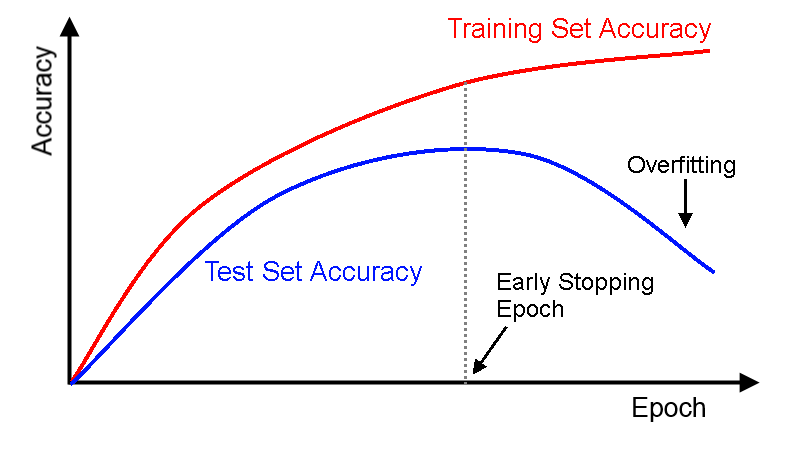

* 저장된 weight 를 다시 불러와서 validation set 에 대한 loss 와 accuracy 를 확인합니다.

In [ ]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predicted_test = gmodel.predict_proba(X_test)

In [ ]:
predicted_test

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

# Reference
Thank you for his best lecture ever!! I made more detailed by listening his lecture! It will be really helpful for starter.

Check out 'You Han Lee' youtube and his kaggle. 

https://www.kaggle.com/youhanlee

https://www.youtube.com/watch?v=uVoagNbaSwo&t=3s